In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from scipy.stats import linregress
from scipy import interpolate

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = ds.LON[jmin:jmax,imin:imax]
lat = ds.LAT[jmin:jmax,imin:imax]
H = np.array(ds.SH[jmin:jmax,imin:imax])

In [4]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

north_alps = np.copy(alps)
north_alps[lon>8.6] = False
north_alps[lat<45] = False
#north_alps[lat>46.5] = False

south_alps = np.copy(alps)
south_alps[lat>45] = False

east_alps = np.copy(alps)
east_alps[lon<8.6] = False

### Defining regions

In [5]:
first_year = 1981
last_year = 2020

RR_month = np.zeros(((last_year-first_year+1),12,91,139)) # Rain
SF_month = np.zeros(((last_year-first_year+1),12,91,139)) # Snowfall

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_RR = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/monthly/MON.ERA5_v1.EUl.MBrr.'+str(year)+'.nc')
    ds_SF = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/monthly/MON.ERA5_v1.EUl.MBsf.'+str(year)+'.nc')
    
    RR_month[year-1981]=ds_RR.MBrr[:,jmin:jmax,imin:imax]
    SF_month[year-1981]=ds_SF.MBsf[:,jmin:jmax,imin:imax]

1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 

In [6]:
# TP = Total Precipitation

TP_month = RR_month+SF_month

TP_month_mean_wp = TP_month.mean(axis=0)

TP_month_mean_wp_argmax = np.argmax(TP_month_mean_wp,axis=0)

In [7]:
# same with EC-Earth3 to compare

first_year = 1981
last_year = 2020

RR_month = np.zeros(((last_year-first_year+1),12,91,139)) # Rain
SF_month = np.zeros(((last_year-first_year+1),12,91,139)) # Snowfall

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year == 2086:
        ds_RR = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/monthly/MON.EC-Earth3_SSP245.EUe.MBrr.'+str(year)+'.nc')
        ds_SF = xr.open_dataset('/bettik/castelli/data/MAR-EC-Earth3/SSP245/ICE.EC-Earth3_SSP245.EUe.MBsf.'+str(year)+'.nc')
        ds_SF = ds_SF.groupby("time.month").mean("time")
    elif year <2015:
        ds_RR = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/monthly/MON.EC-Earth3_HIST.EUe.MBrr.'+str(year)+'.nc')
        ds_SF = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/monthly/MON.EC-Earth3_HIST.EUe.MBsf.'+str(year)+'.nc')
    else:
        ds_RR = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/monthly/MON.EC-Earth3_SSP245.EUe.MBrr.'+str(year)+'.nc')
        ds_SF = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/monthly/MON.EC-Earth3_SSP245.EUe.MBsf.'+str(year)+'.nc')
    
    RR_month[year-1981]=ds_RR.MBrr[:,jmin:jmax,imin:imax]
    SF_month[year-1981]=ds_SF.MBsf[:,jmin:jmax,imin:imax]

1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 

In [8]:
# TP = Total Precipitation

TP_month_ECEarth = RR_month+SF_month

TP_month_ECEarth_mean_wp = TP_month_ECEarth.mean(axis=0)

TP_month_ECEarth_mean_wp_argmax = np.argmax(TP_month_ECEarth_mean_wp,axis=0)

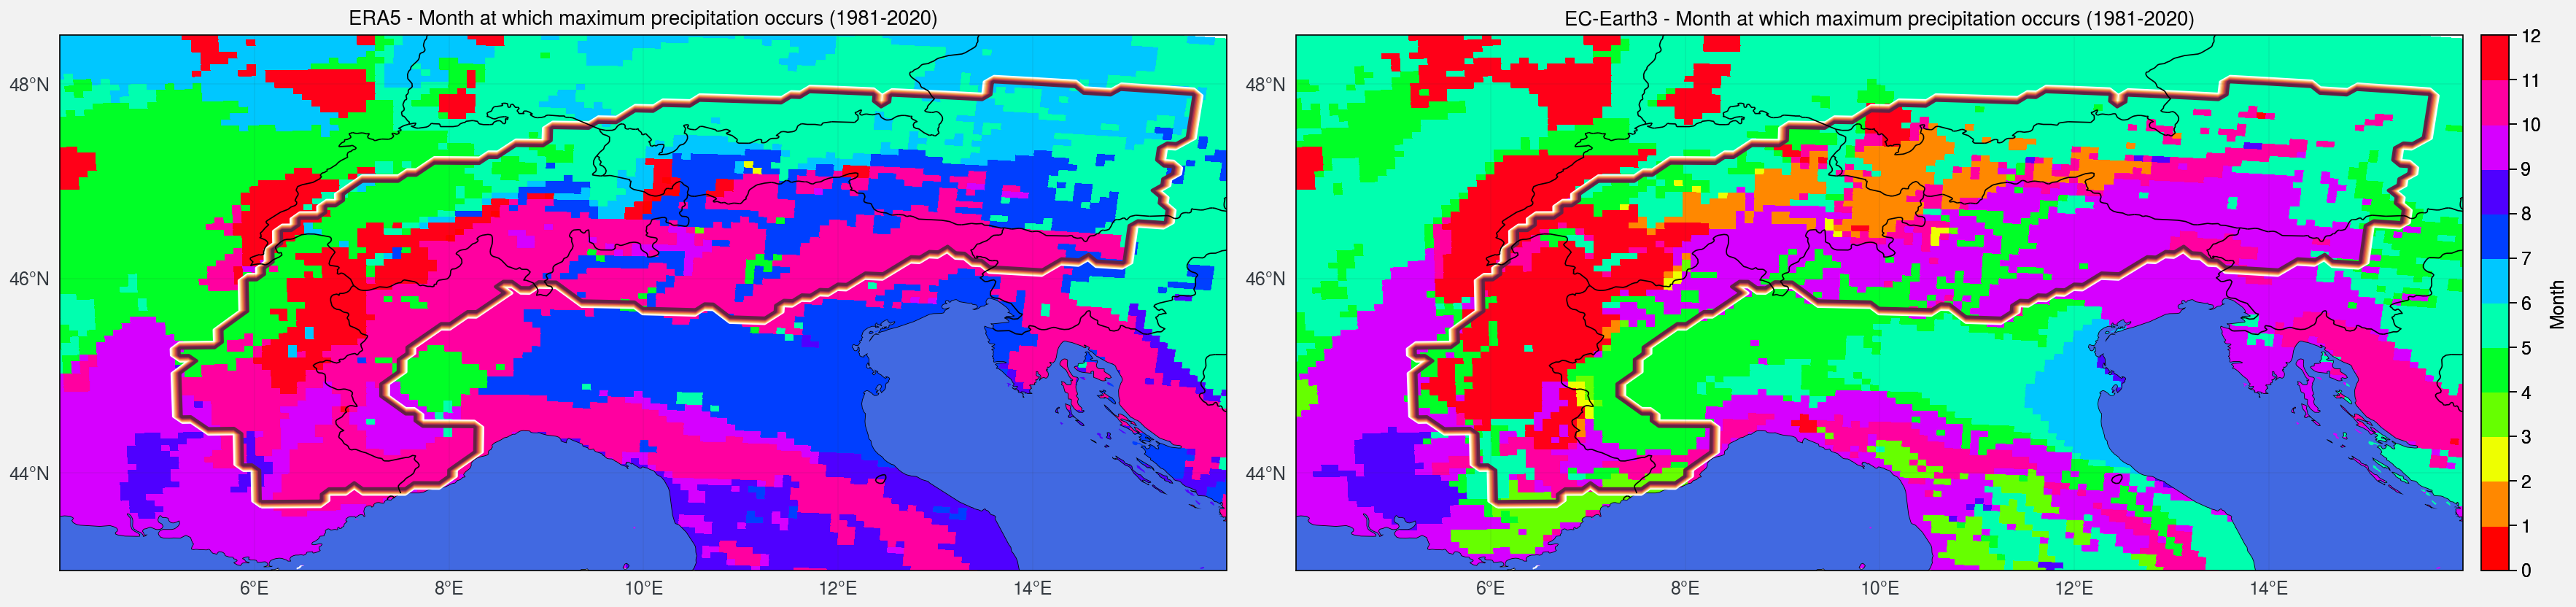

In [8]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)
m=axs[0].pcolormesh(lon, lat, TP_month_mean_wp_argmax+0.1, levels=12,cmap='hsv')
f.colorbar(m,label= 'Month')

axs[0].contour(lon, lat,alps)
axs[0].format(**normal_format,title='ERA5 - Month at which maximum precipitation occurs (1981-2020)')
axs[0].format(ocean=True,oceancolor='royalblue',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])

m=axs[1].pcolormesh(lon, lat, TP_month_ECEarth_mean_wp_argmax+0.1, levels=12,cmap='hsv')

axs[1].contour(lon, lat,alps)
axs[1].format(**normal_format,title='EC-Earth3 - Month at which maximum precipitation occurs (1981-2020)')
axs[1].format(ocean=True,oceancolor='royalblue',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])

In [8]:
regions_wp = np.zeros((91,139))


for i in range(91):
    for j in range(139):
        if (TP_month_mean_wp_argmax[i,j] == 5 or TP_month_mean_wp_argmax[i,j] == 6 or TP_month_mean_wp_argmax[i,j] == 7
            or TP_month_mean_wp_argmax[i,j] == 8):
            regions_wp[i,j] = 1
        elif (TP_month_mean_wp_argmax[i,j] == 3 or TP_month_mean_wp_argmax[i,j] == 4 or TP_month_mean_wp_argmax[i,j] == 9
            or TP_month_mean_wp_argmax[i,j] == 10):
            regions_wp[i,j] = 2
        else:
            regions_wp[i,j] = 3

In [9]:
regions_wp_ECEarth = np.zeros((91,139))


for i in range(91):
    for j in range(139):
        if (TP_month_ECEarth_mean_wp_argmax[i,j] == 5 or TP_month_ECEarth_mean_wp_argmax[i,j] == 6 or TP_month_ECEarth_mean_wp_argmax[i,j] == 7
            or TP_month_ECEarth_mean_wp_argmax[i,j] == 8):
            regions_wp_ECEarth[i,j] = 1
        elif (TP_month_ECEarth_mean_wp_argmax[i,j] == 3 or TP_month_ECEarth_mean_wp_argmax[i,j] == 4 or TP_month_ECEarth_mean_wp_argmax[i,j] == 9
            or TP_month_ECEarth_mean_wp_argmax[i,j] == 10):
            regions_wp_ECEarth[i,j] = 2
        else:
            regions_wp_ECEarth[i,j] = 3

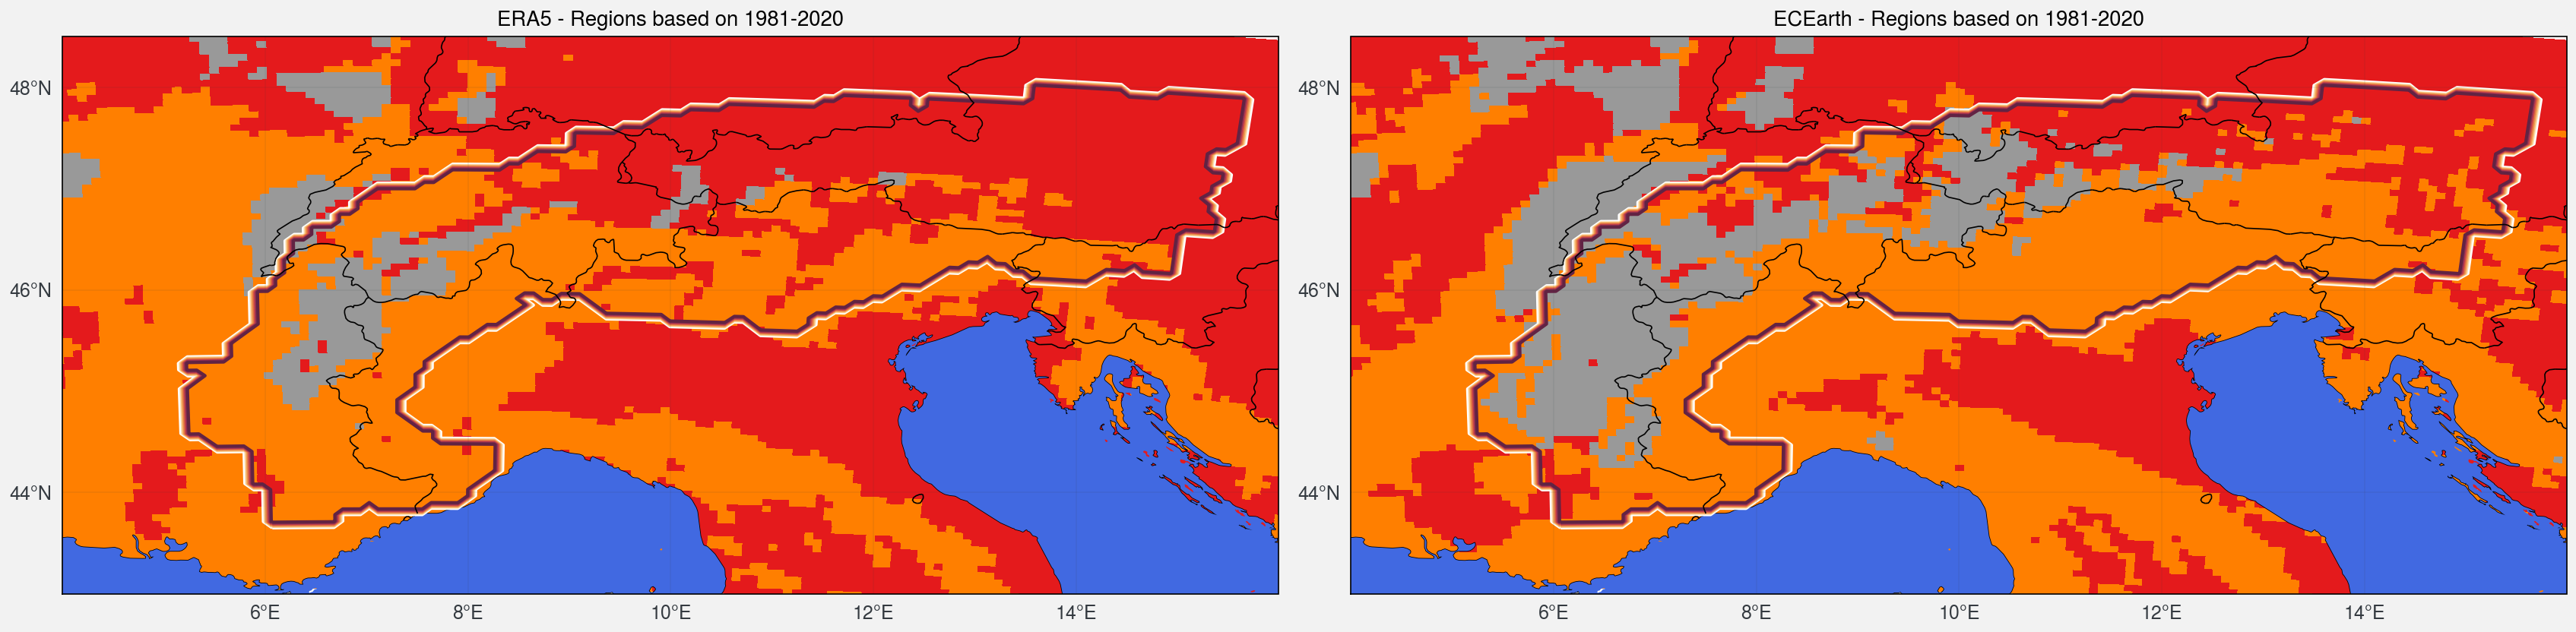

In [11]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)

# Whole period
m=axs[0].pcolormesh(lon, lat, regions_wp+0.1, levels=3,cmap='Set1')

axs[0].contour(lon, lat,alps)
axs[0].format(**normal_format,title='ERA5 - Regions based on 1981-2020')
axs[0].format(ocean=True,oceancolor='royalblue',reso='hi')

m=axs[1].pcolormesh(lon, lat, regions_wp_ECEarth+0.1, levels=3,cmap='Set1')

axs[1].contour(lon, lat,alps)
axs[1].format(**normal_format,title='ECEarth - Regions based on 1981-2020')
axs[1].format(ocean=True,oceancolor='royalblue',reso='hi')

### Kmeans

In [8]:
kmeans = KMeans(
    init="random",
    n_clusters=8,
    n_init=10,
    max_iter=300
)

In [9]:
mean_TP = TP_month_ECEarth_mean_wp.mean(axis=0)
norm_TP_month_ECEarth_mean_wp = TP_month_ECEarth_mean_wp/mean_TP[None,:]
norm_TP_month_ECEarth_mean_wp_reshape = np.reshape(norm_TP_month_ECEarth_mean_wp,(12,12649))
norm_TP_month_ECEarth_mean_wp_reshape_T = np.transpose(norm_TP_month_ECEarth_mean_wp_reshape)
mean_TP.shape

(91, 139)

In [10]:
norm_TP_month_ECEarth_mean_wp = TP_month_ECEarth_mean_wp/mean_TP[None,:]
norm_TP_month_ECEarth_mean_wp_reshape = np.reshape(norm_TP_month_ECEarth_mean_wp,(12,12649))
norm_TP_month_ECEarth_mean_wp_reshape_T = np.transpose(norm_TP_month_ECEarth_mean_wp_reshape)

kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300
)


kmeans.fit(norm_TP_month_ECEarth_mean_wp_reshape_T)

KMeans(init='random', n_clusters=3, n_init=10)

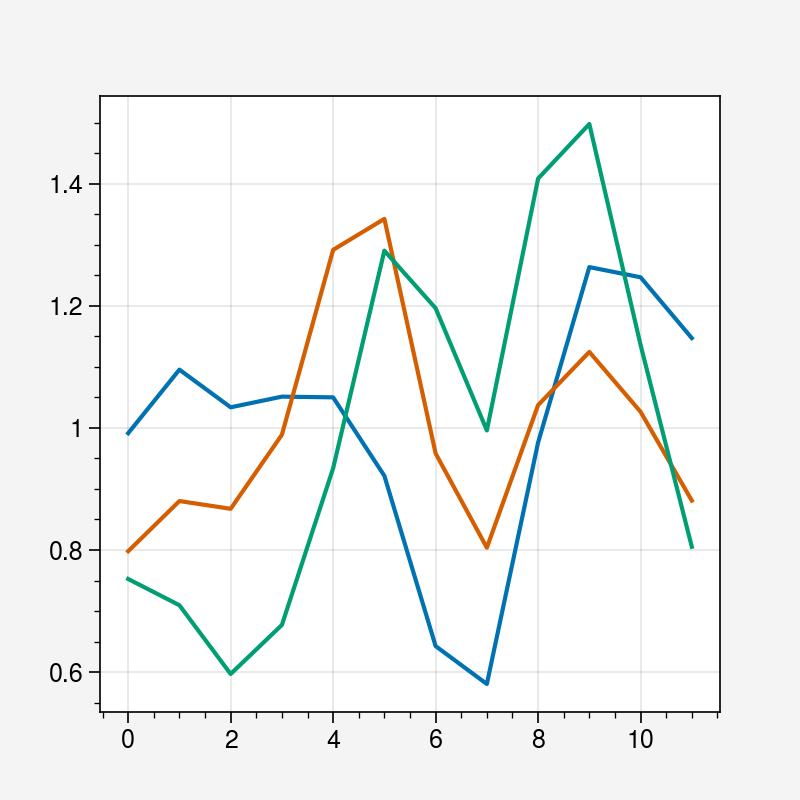

In [11]:
for i in range(3):
    plt.plot(kmeans.cluster_centers_[i])

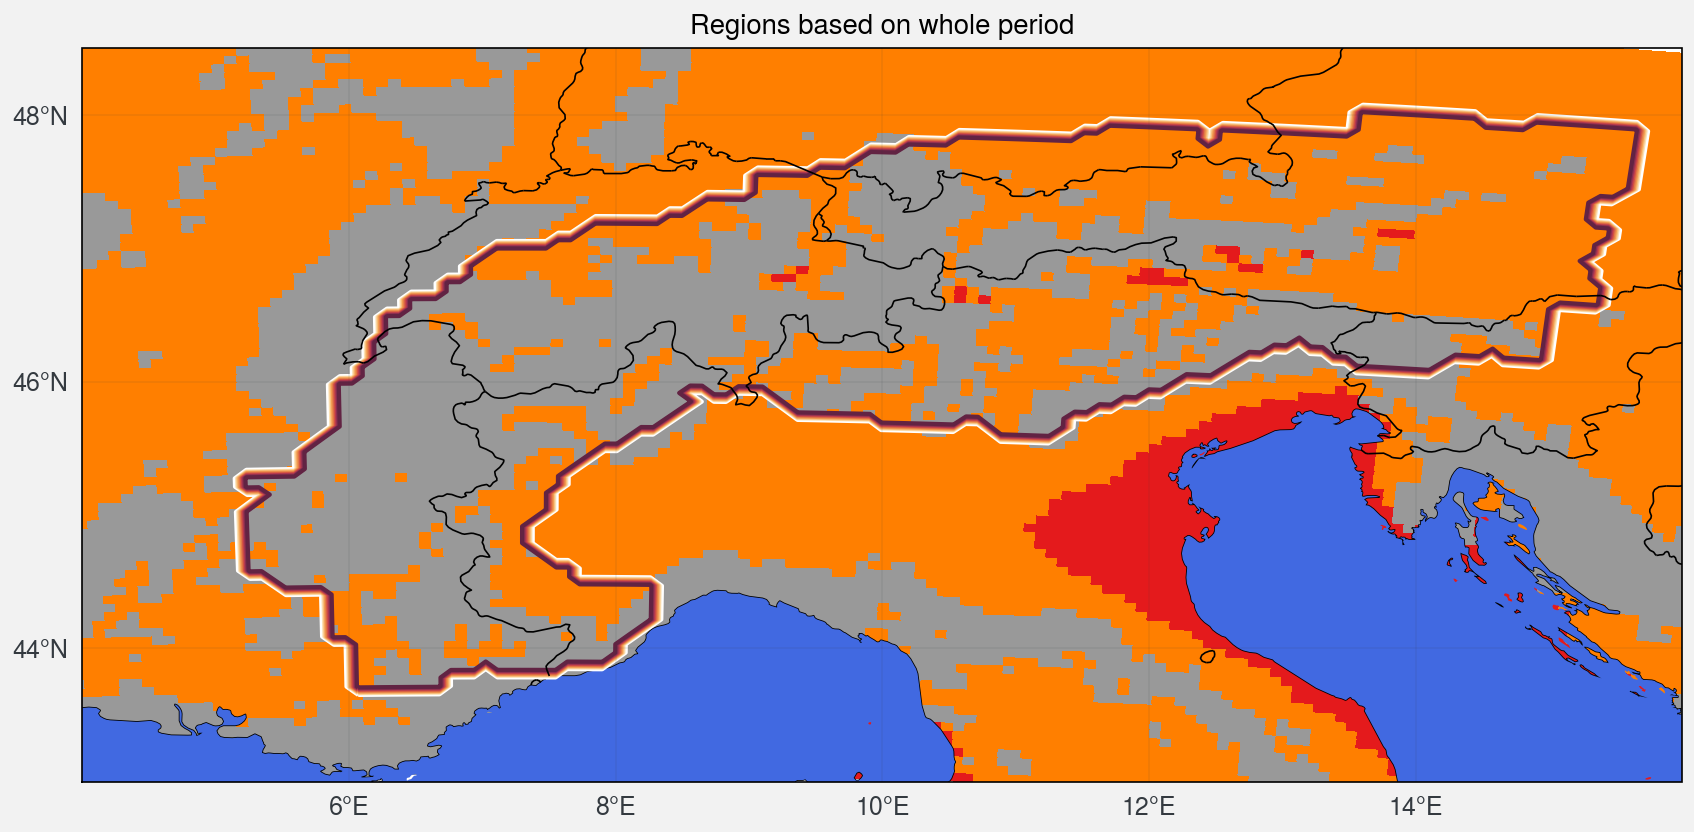

In [16]:
f, ax = pplt.subplots(proj='cyl', axwidth=8)

# Whole period
m=ax.pcolormesh(lon, lat, np.reshape(kmeans.labels_,(91,139))+0.1, levels=3,cmap='Set1')

ax.contour(lon, lat,alps)
ax.format(**normal_format,title='Regions based on whole period')
ax.format(ocean=True,oceancolor='royalblue',reso='hi')

In [12]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(norm_TP_month_ECEarth_mean_wp_reshape_T)
    sse.append(kmeans.inertia_)

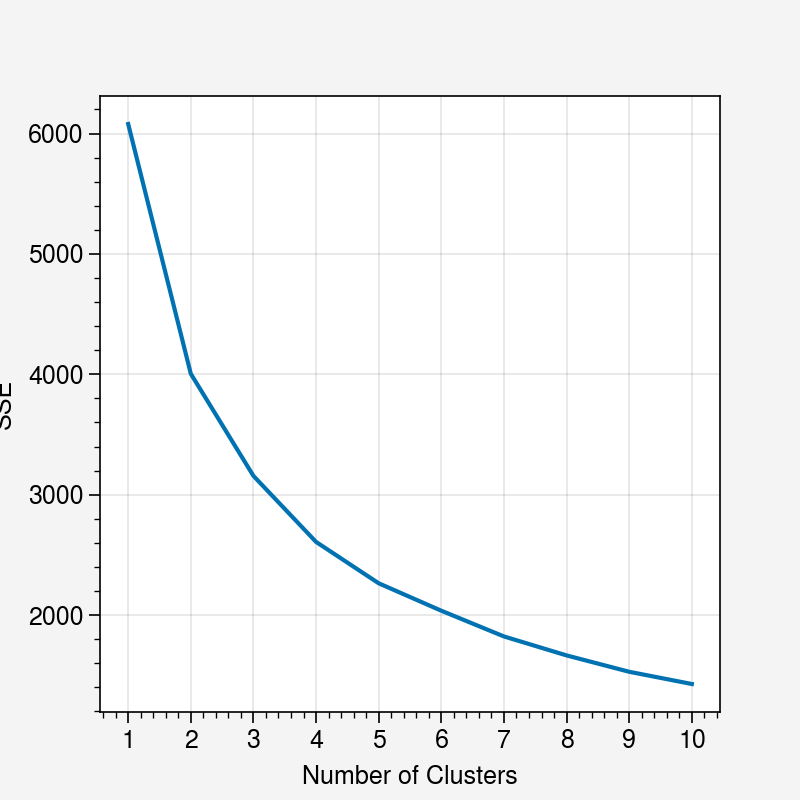

In [13]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [14]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

4

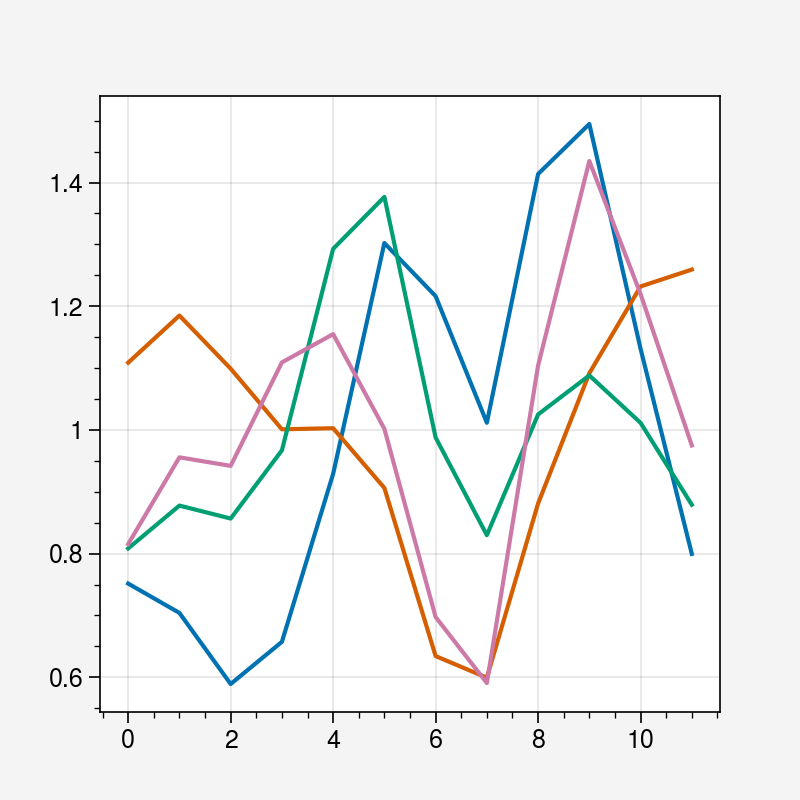

In [15]:
k = kl.elbow

kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
kmeans.fit(norm_TP_month_ECEarth_mean_wp_reshape_T)

for i in range(k):
    plt.plot(kmeans.cluster_centers_[i])

In [16]:
def do_kmeans(data):
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300
    }
    
    # A list holds the SSE values for each k
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    
    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

    k = kl.elbow
    
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    
    return k, kmeans.cluster_centers_, np.reshape(kmeans.labels_,(91,139))

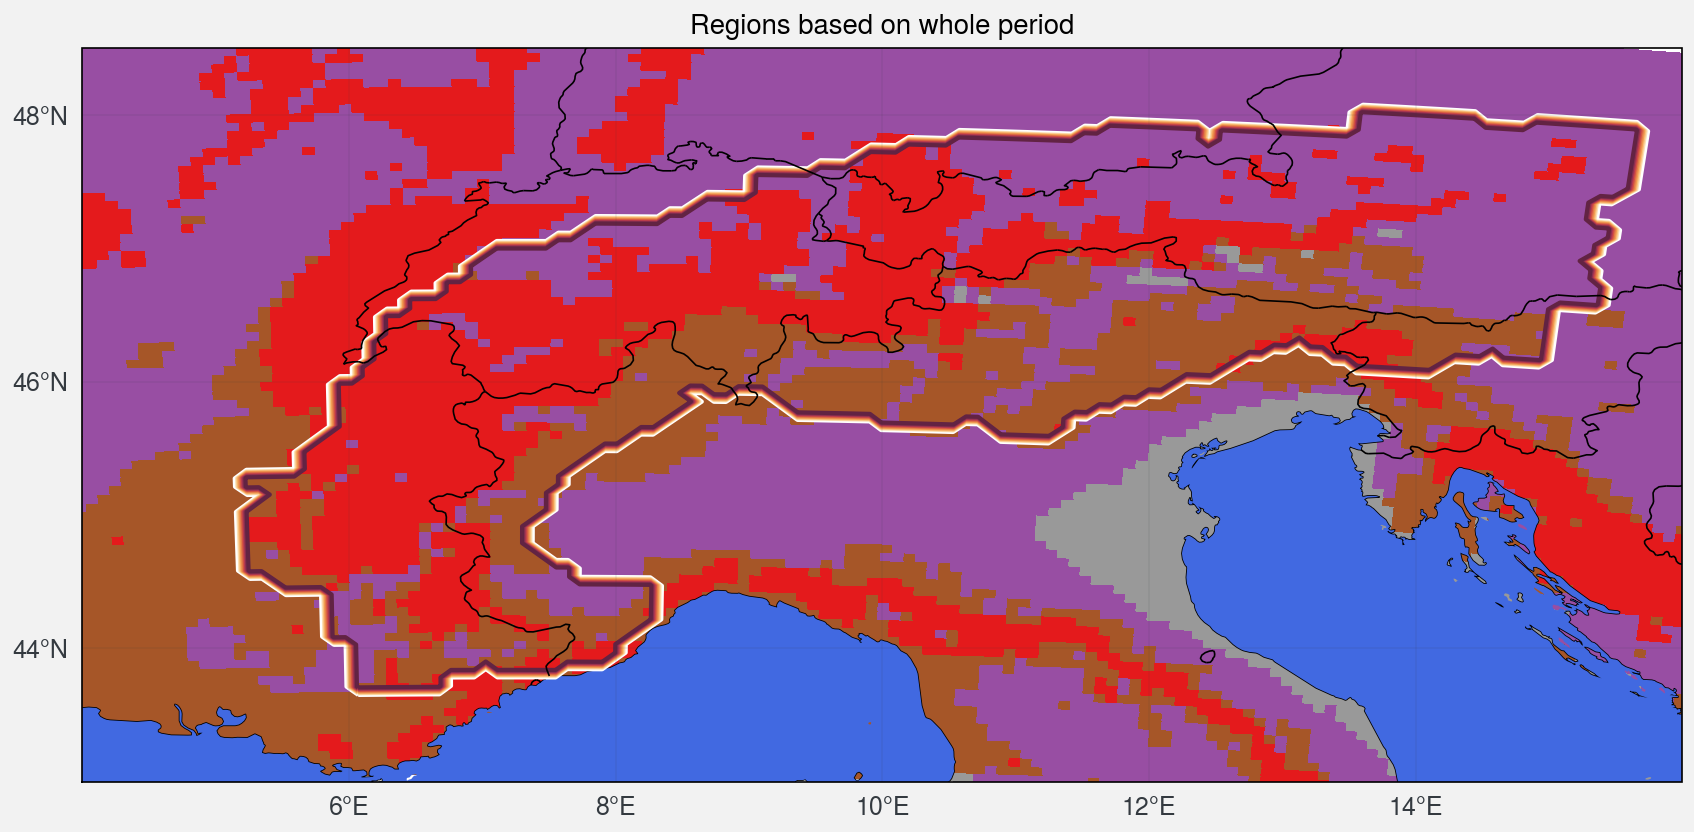

In [22]:
f, ax = pplt.subplots(proj='cyl', axwidth=8)

# Whole period
m=ax.pcolormesh(lon, lat, np.reshape(kmeans.labels_,(91,139))+0.1, levels=4,cmap='Set1')

ax.contour(lon, lat,alps)
ax.format(**normal_format,title='Regions based on whole period')
ax.format(ocean=True,oceancolor='royalblue',reso='hi')

In [17]:
# ERA5
mean_TP_ERA5 = TP_month_mean_wp.mean(axis=0)
norm_TP_month_ERA5_mean_wp = TP_month_mean_wp/mean_TP_ERA5[None,:]
norm_TP_month_ERA5_mean_wp_reshape = np.reshape(norm_TP_month_ERA5_mean_wp,(12,12649))
norm_TP_month_ERA5_mean_wp_reshape_T = np.transpose(norm_TP_month_ERA5_mean_wp_reshape)

k_ERA5, clustercenters_ERA5, labels_ERA5 = do_kmeans(norm_TP_month_ERA5_mean_wp_reshape_T)

# EC-Earth3
mean_TP_ECEarth = TP_month_ECEarth_mean_wp.mean(axis=0)
norm_TP_month_ECEarth_mean_wp = TP_month_ECEarth_mean_wp/mean_TP_ECEarth[None,:]
norm_TP_month_ECEarth_mean_wp_reshape = np.reshape(norm_TP_month_ECEarth_mean_wp,(12,12649))
norm_TP_month_ECEarth_mean_wp_reshape_T = np.transpose(norm_TP_month_ECEarth_mean_wp_reshape)

k_ECEarth, clustercenters_ECEarth, labels_ECEarth = do_kmeans(norm_TP_month_ECEarth_mean_wp_reshape_T)

In [18]:
print(k_ERA5,k_ECEarth)

4 4


(<matplotlib.legend.Legend at 0x7faff8165d00>,
 <matplotlib.legend.Legend at 0x7faff8165e20>)

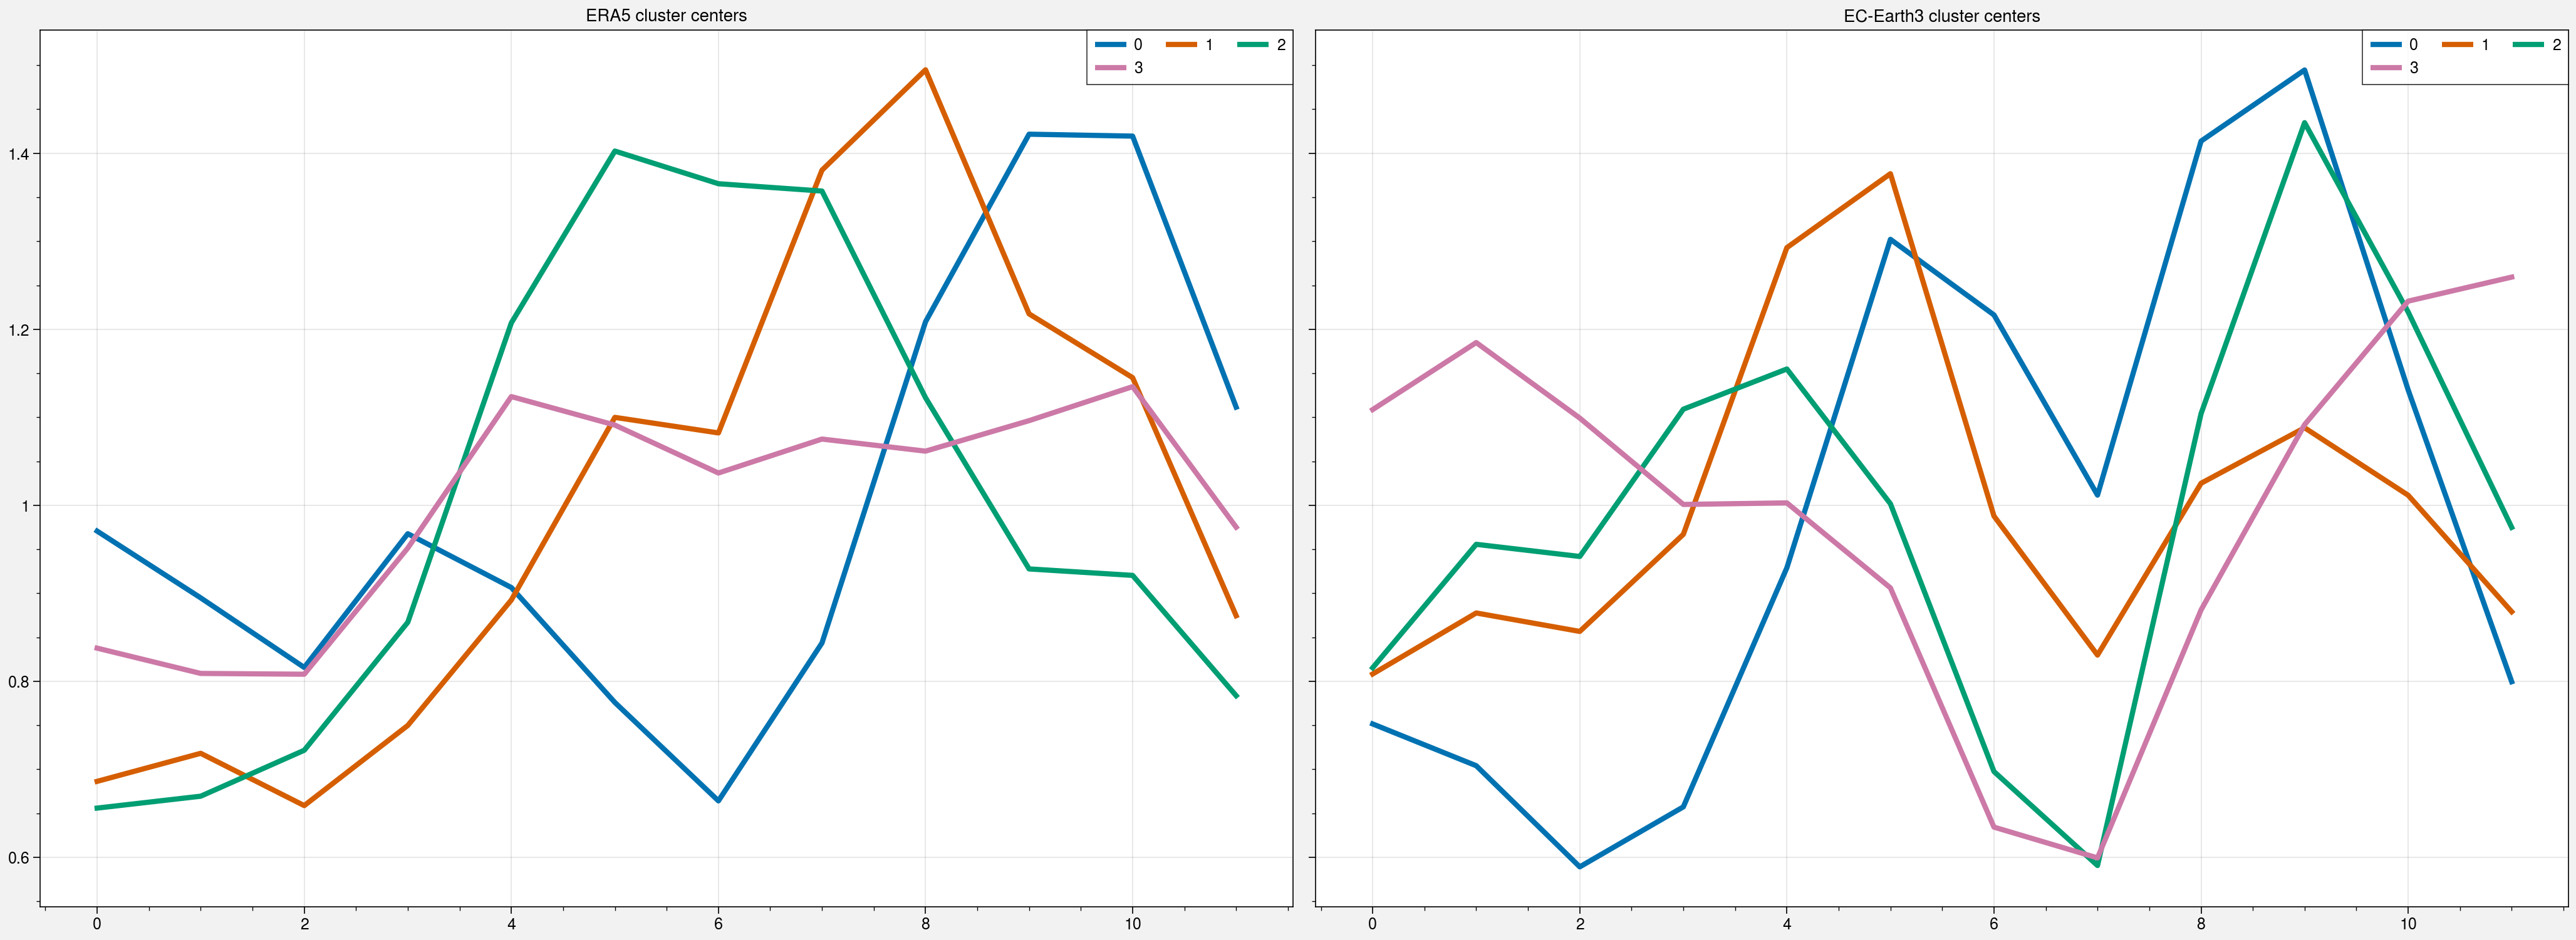

In [21]:
f,axs = pplt.subplots(axheight=7,axwidth=10,ncols=2)

for i in range(k_ERA5):
    axs[0].plot(clustercenters_ERA5[i],linewidth=3,label=i)
    axs[0].format(title='ERA5 cluster centers',cmap='Set1')

for i in range(k_ECEarth):
    axs[1].plot(clustercenters_ECEarth[i],linewidth=3,label=i)
    axs[1].format(title='EC-Earth3 cluster centers')

axs.legend()

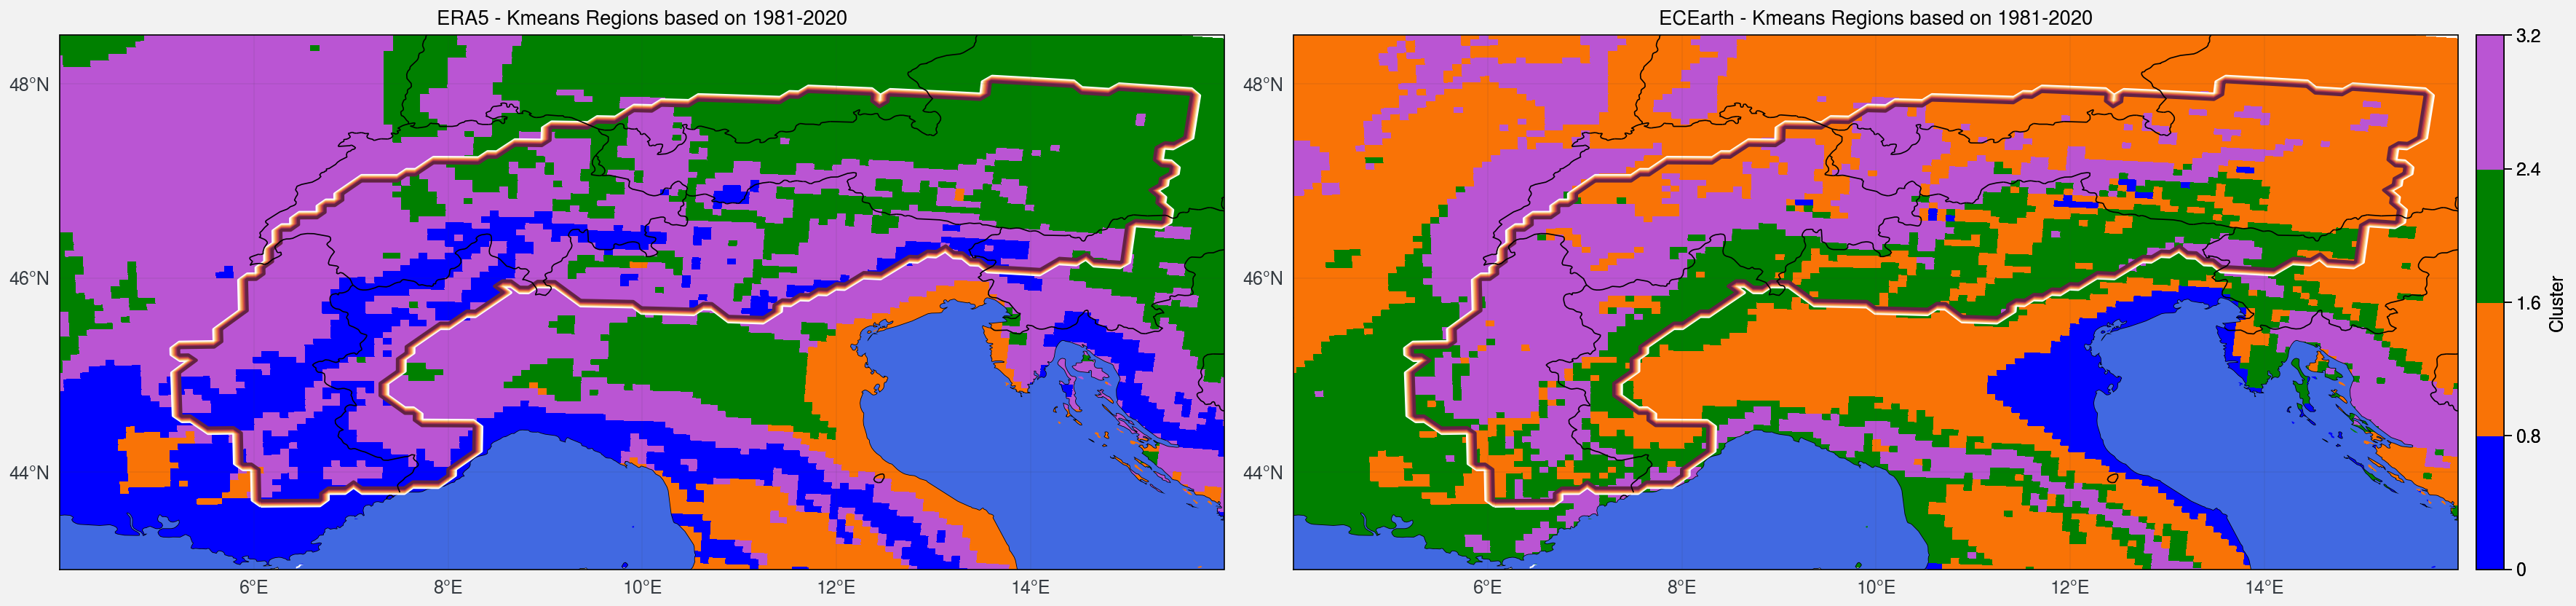

In [22]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)

custom_cmap = ["b","orange","g","mediumorchid"]

# Whole period
m=axs[0].pcolormesh(lon, lat, labels_ERA5+0.1, levels=4,cmap=custom_cmap)
f.colorbar(m,label= 'Cluster')
axs[0].contour(lon, lat,alps)
axs[0].format(**normal_format,title='ERA5 - Kmeans Regions based on 1981-2020')
axs[0].format(ocean=True,oceancolor='royalblue',reso='hi')

m=axs[1].pcolormesh(lon, lat, labels_ECEarth+0.1, levels=4,cmap=custom_cmap)

axs[1].contour(lon, lat,alps)
axs[1].format(**normal_format,title='ECEarth - Kmeans Regions based on 1981-2020')
axs[1].format(ocean=True,oceancolor='royalblue',reso='hi')

#### Kmeans over the Alps only

In [9]:
def do_kmeans2(data):
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300
    }
    
    # A list holds the SSE values for each k
    sse = []
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    
    kl = KneeLocator(range(2, 11), sse, curve="convex", direction="decreasing")

    k = kl.elbow
    
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    
    return k, kmeans.cluster_centers_, np.reshape(kmeans.labels_,(91,139))

In [10]:
alps_months = np.repeat(alps[np.newaxis,:,:],12,axis=0)

TP_month_ERA5_mean_wp_alps = np.ma.masked_array(TP_month_mean_wp, mask=np.invert(alps_months))
TP_month_ECEarth_mean_wp_alps = np.ma.masked_array(TP_month_ECEarth_mean_wp, mask=np.invert(alps_months))

In [11]:
# For the Alps

# ERA5
mean_TP_ERA5 = TP_month_ERA5_mean_wp_alps.mean(axis=0)
norm_TP_month_ERA5_mean_wp = TP_month_ERA5_mean_wp_alps/mean_TP_ERA5[None,:]
norm_TP_month_ERA5_mean_wp_reshape = np.reshape(norm_TP_month_ERA5_mean_wp,(12,12649))
norm_TP_month_ERA5_mean_wp_reshape_T = np.transpose(norm_TP_month_ERA5_mean_wp_reshape)
norm_TP_month_ERA5_mean_wp_reshape_T[norm_TP_month_ERA5_mean_wp_reshape_T.mask] = 0

k_ERA5, clustercenters_ERA5, labels_ERA5 = do_kmeans2(norm_TP_month_ERA5_mean_wp_reshape_T)

# EC-Earth3
mean_TP_ECEarth = TP_month_ECEarth_mean_wp_alps.mean(axis=0)
norm_TP_month_ECEarth_mean_wp = TP_month_ECEarth_mean_wp_alps/mean_TP_ECEarth[None,:]
norm_TP_month_ECEarth_mean_wp_reshape = np.reshape(norm_TP_month_ECEarth_mean_wp,(12,12649))
norm_TP_month_ECEarth_mean_wp_reshape_T = np.transpose(norm_TP_month_ECEarth_mean_wp_reshape)
norm_TP_month_ECEarth_mean_wp_reshape_T[norm_TP_month_ECEarth_mean_wp_reshape_T.mask] = 0

k_ECEarth, clustercenters_ECEarth, labels_ECEarth = do_kmeans2(norm_TP_month_ECEarth_mean_wp_reshape_T)

In [12]:
print(k_ERA5,k_ECEarth)

4 4


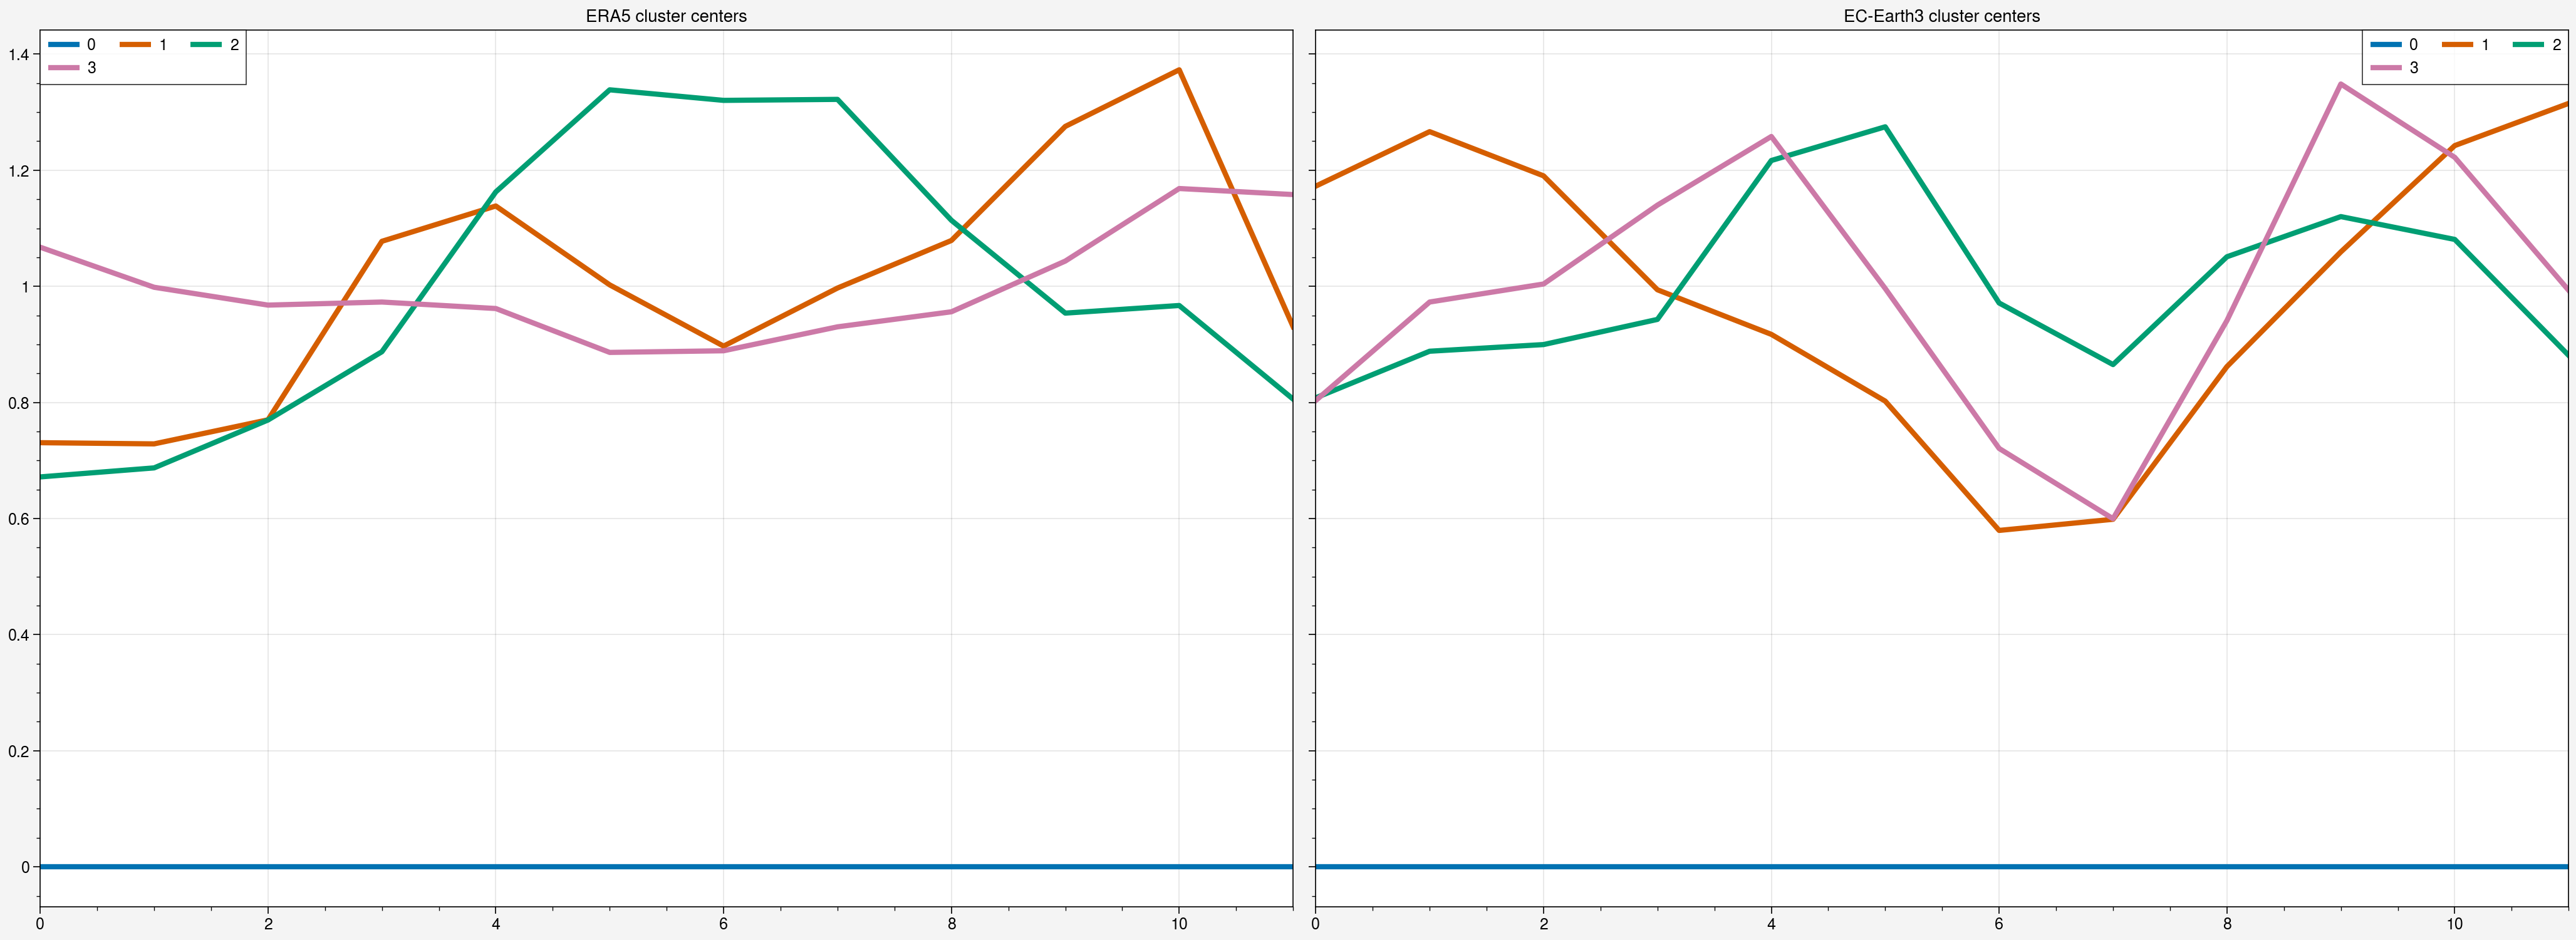

In [18]:
f,axs = pplt.subplots(ncols=2,axheight=7,axwidth=10)

for i in range(k_ERA5):
    axs[0].plot(clustercenters_ERA5[i],linewidth=3,label=i)
    axs[0].format(title='ERA5 cluster centers')#,cmap='Set1')

for i in range(k_ECEarth):
    axs[1].plot(clustercenters_ECEarth[i],linewidth=3,label=i)
    axs[1].format(title='EC-Earth3 cluster centers')

axs[0].legend()
axs[1].legend()

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


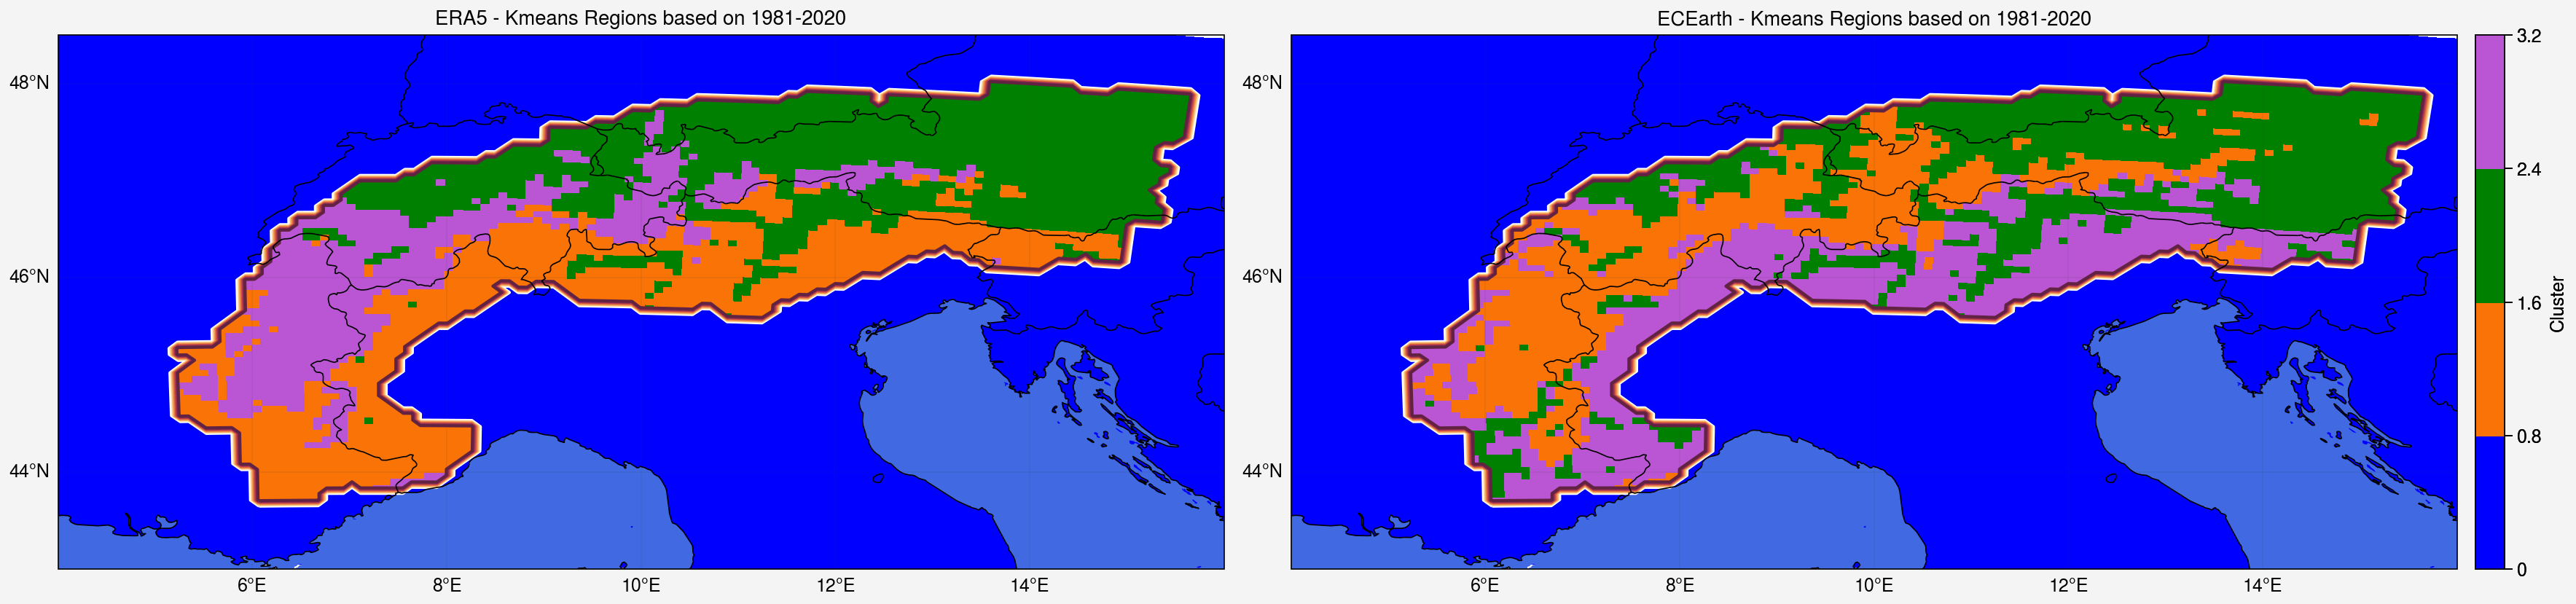

In [25]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)

custom_cmap = ["b","orange","g","mediumorchid"]

# Whole period
m=axs[0].pcolormesh(lon, lat, labels_ERA5+0.1, levels=4,cmap=custom_cmap)
f.colorbar(m,label= 'Cluster')
axs[0].contour(lon, lat,alps)
axs[0].format(**normal_format,title='ERA5 - Kmeans Regions based on 1981-2020')
axs[0].format(ocean=True,oceancolor='royalblue',reso='hi')

m=axs[1].pcolormesh(lon, lat, labels_ECEarth+0.1, levels=4,cmap=custom_cmap)

axs[1].contour(lon, lat,alps)
axs[1].format(**normal_format,title='ECEarth - Kmeans Regions based on 1981-2020')
axs[1].format(ocean=True,oceancolor='royalblue',reso='hi')

#### Testing

In [23]:
mean_TP_ERA5 = TP_month_ERA5_mean_wp_alps.mean(axis=0)
norm_TP_month_ERA5_mean_wp = TP_month_ERA5_mean_wp_alps/mean_TP_ERA5[None,:]

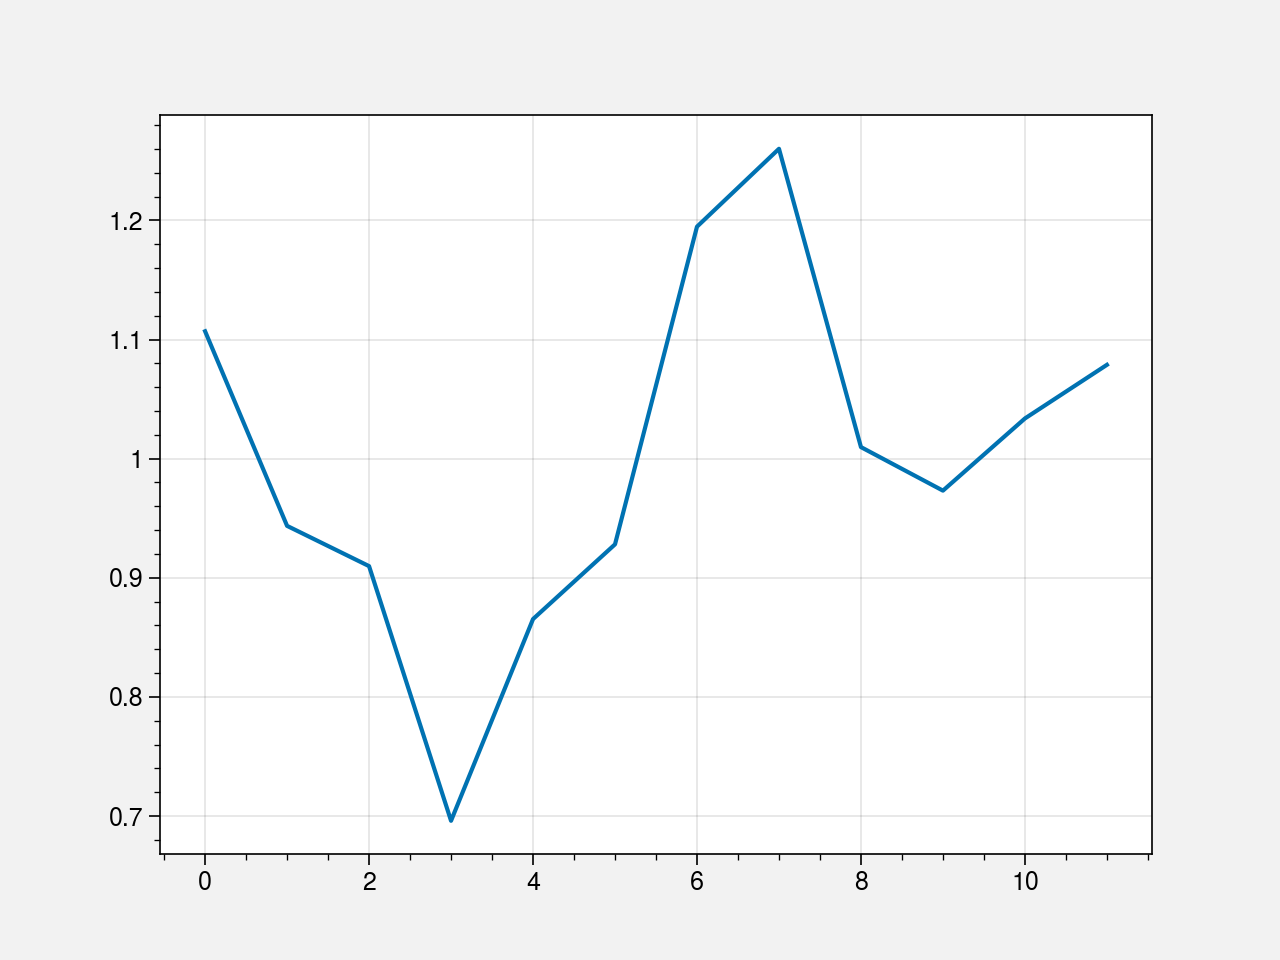

In [32]:
plt.plot(norm_TP_month_ERA5_mean_wp[:,60,70])

In [60]:
norm_TP_month_ERA5_mean_wp_reshape = np.reshape(norm_TP_month_ERA5_mean_wp,(12,12649))
norm_TP_month_ERA5_mean_wp_reshape_T = np.transpose(norm_TP_month_ERA5_mean_wp_reshape)
norm_TP_month_ERA5_mean_wp_reshape_T[norm_TP_month_ERA5_mean_wp_reshape_T.mask] = 0

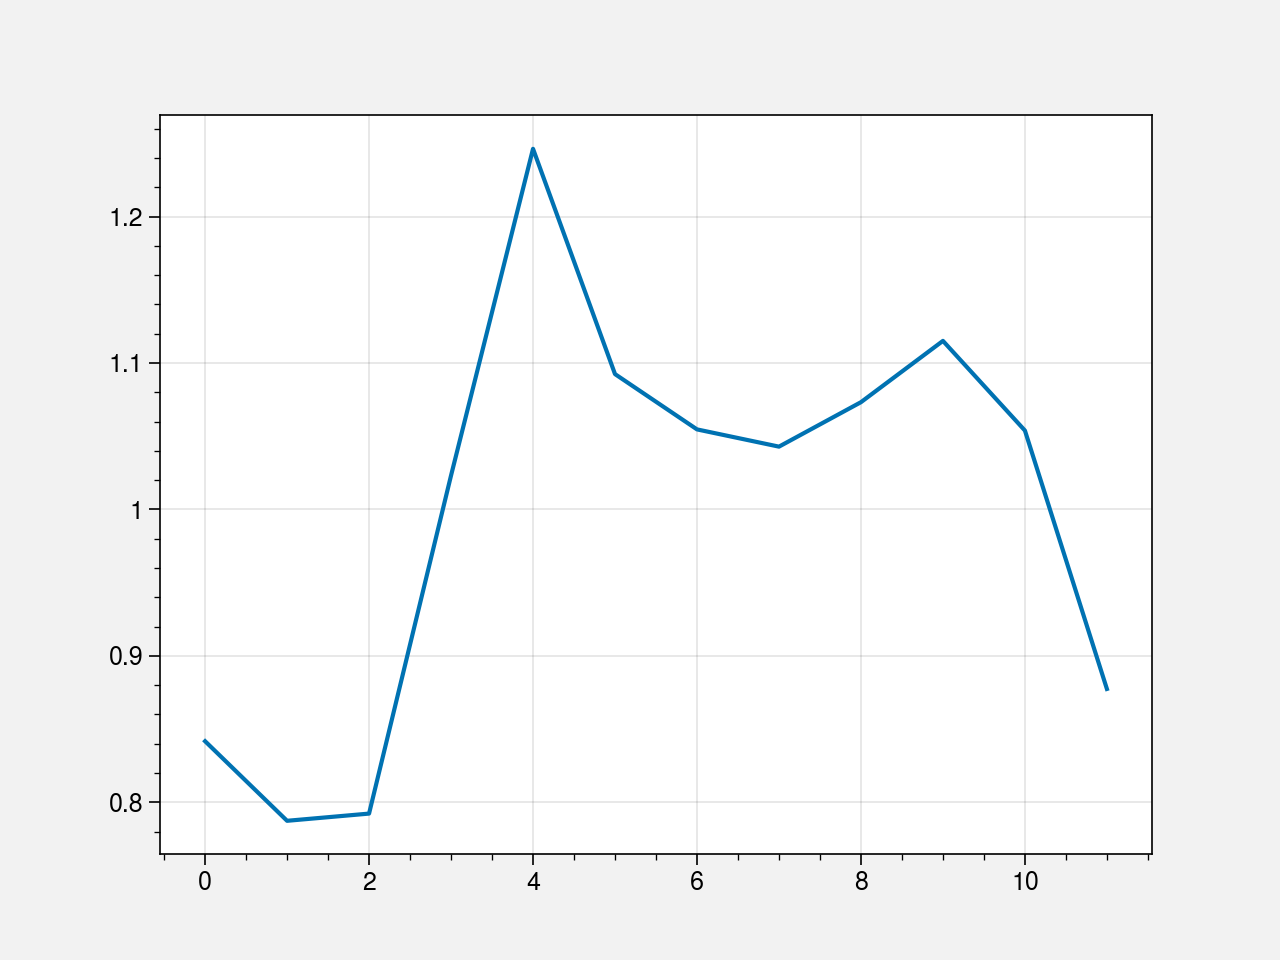

In [62]:
plt.plot(norm_TP_month_ERA5_mean_wp_reshape_T.data[6000,:])

In [63]:
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    max_iter=300
)

kmeans.fit(norm_TP_month_ERA5_mean_wp_reshape_T)

KMeans(init='random', n_clusters=4)

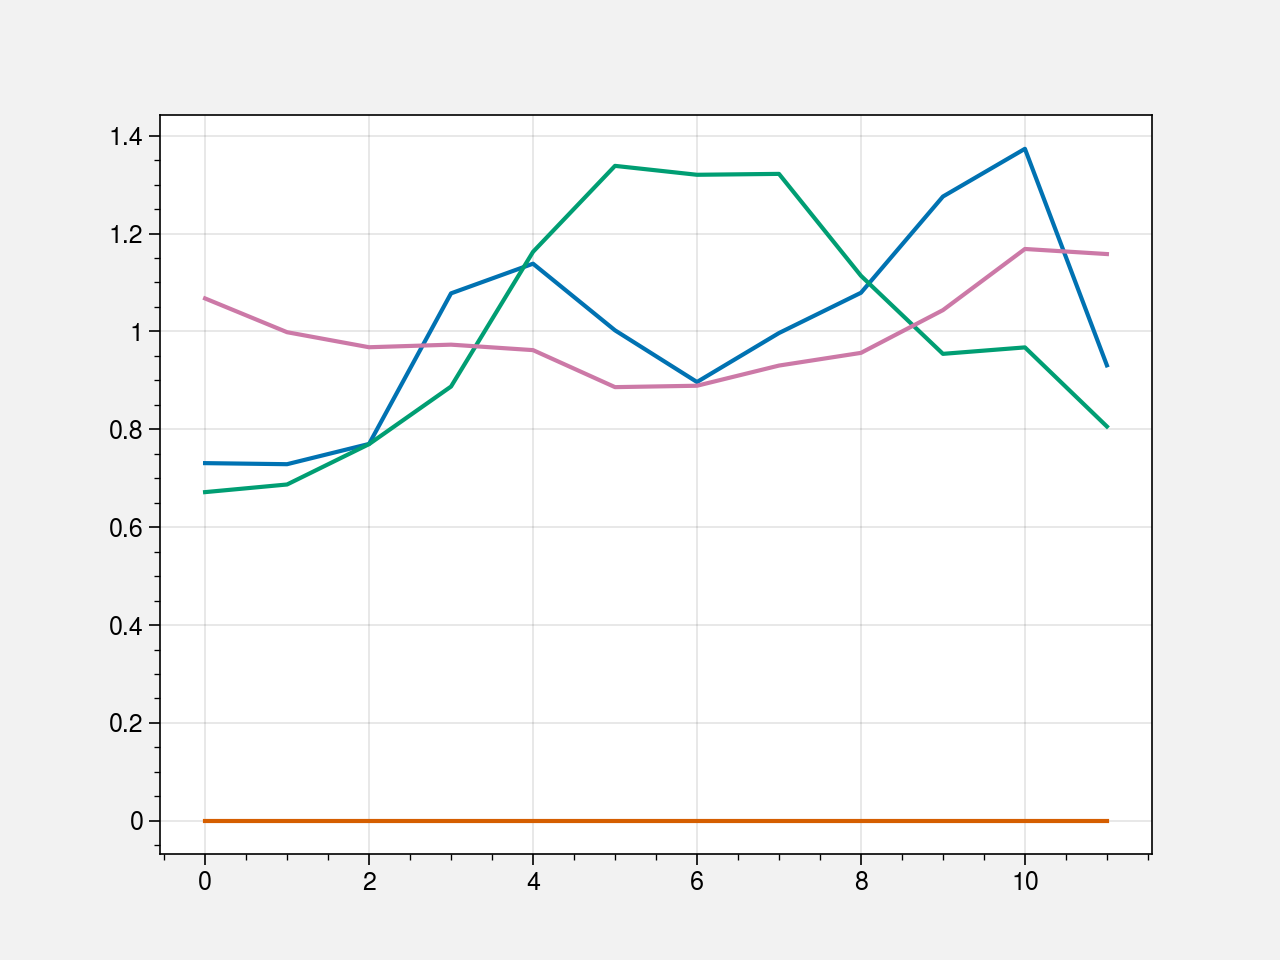

In [64]:
for i in range(4):
    plt.plot(kmeans.cluster_centers_[i])

### Back

In [26]:
ne_alps = np.copy(east_alps) # ne : north-east
ne_alps[lon<9.6] = False
ne_alps[lat<46.7] = False

In [27]:
nw_alps1 = np.copy(alps) # nw : north-west
nw_alps1[lon>9.6] = False
nw_alps1[lat<46.6] = False

nw_alps2 = np.copy(alps) # nw : north-west
nw_alps2[lon>7.9] = False
nw_alps2[lat<45.9] = False

nw_alps3 = np.copy(alps) # nw : north-west
nw_alps3[lon>6.9] = False
nw_alps3[lat<44.8] = False

nw_alps4 = np.copy(alps) # nw : north-west
nw_alps4[lon>8.3] = False
nw_alps4[lat<46.4] = False

nw_alps5 = np.copy(alps) # nw : north-west
nw_alps5[lon>7.1] = False
nw_alps5[lat<45.2] = False

nw_alps = np.logical_or(np.logical_or(np.logical_or(np.logical_or(nw_alps1,nw_alps2),nw_alps3),nw_alps4),nw_alps5)

In [28]:
s_alps = np.logical_and(alps,np.invert(np.logical_or(nw_alps,ne_alps)))

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


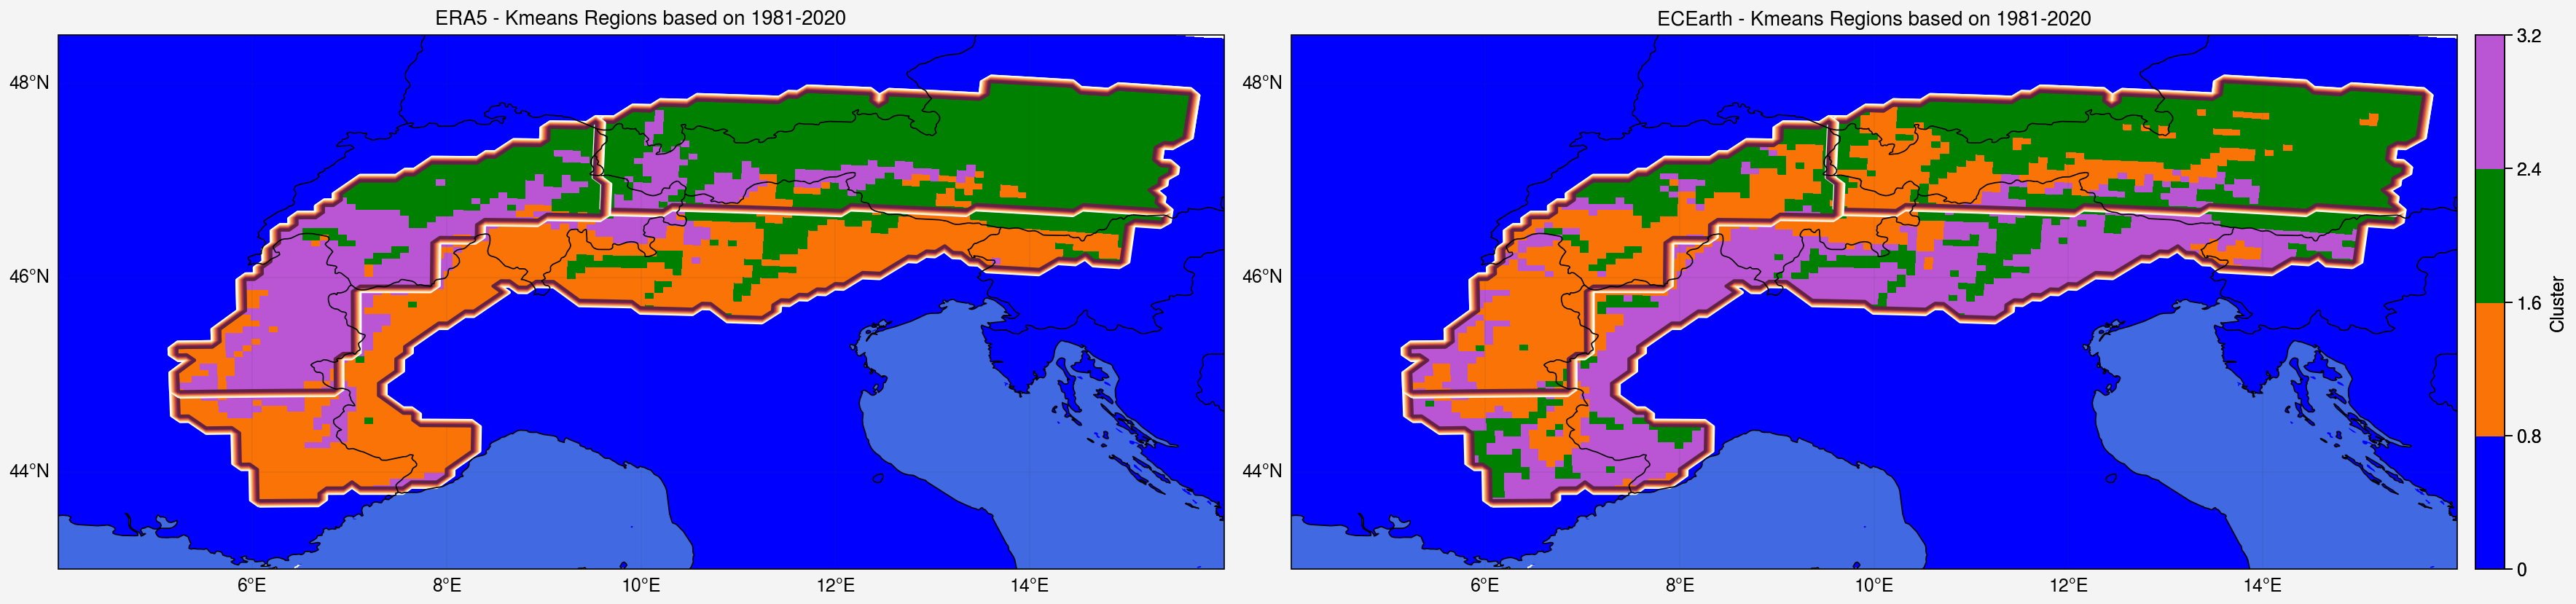

In [29]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)

custom_cmap = ["b","orange","g","mediumorchid"]

# Whole period
m=axs[0].pcolormesh(lon, lat, labels_ERA5+0.1, levels=4,cmap=custom_cmap)
f.colorbar(m,label= 'Cluster')
axs[0].contour(lon, lat,alps)
axs[0].contour(lon, lat,ne_alps)
axs[0].contour(lon, lat,nw_alps)
#axs[0].contour(lon, lat,nw_alps1)
#axs[0].contour(lon, lat,nw_alps2)
#axs[0].contour(lon, lat,nw_alps3)
#axs[0].contour(lon, lat,nw_alps4)
#axs[0].contour(lon, lat,nw_alps5)
axs[0].format(**normal_format,title='ERA5 - Kmeans Regions based on 1981-2020')
axs[0].format(ocean=True,oceancolor='royalblue',reso='hi')

m=axs[1].pcolormesh(lon, lat, labels_ECEarth+0.1, levels=4,cmap=custom_cmap)

axs[1].contour(lon, lat,alps)
axs[1].contour(lon, lat,ne_alps)
axs[1].contour(lon, lat,nw_alps)
#axs[1].contour(lon, lat,nw_alps1)
#axs[1].contour(lon, lat,nw_alps2)
#axs[1].contour(lon, lat,nw_alps3)
#axs[1].contour(lon, lat,nw_alps4)
#axs[1].contour(lon, lat,nw_alps5)
axs[1].format(**normal_format,title='ECEarth - Kmeans Regions based on 1981-2020')
axs[1].format(ocean=True,oceancolor='royalblue',reso='hi')

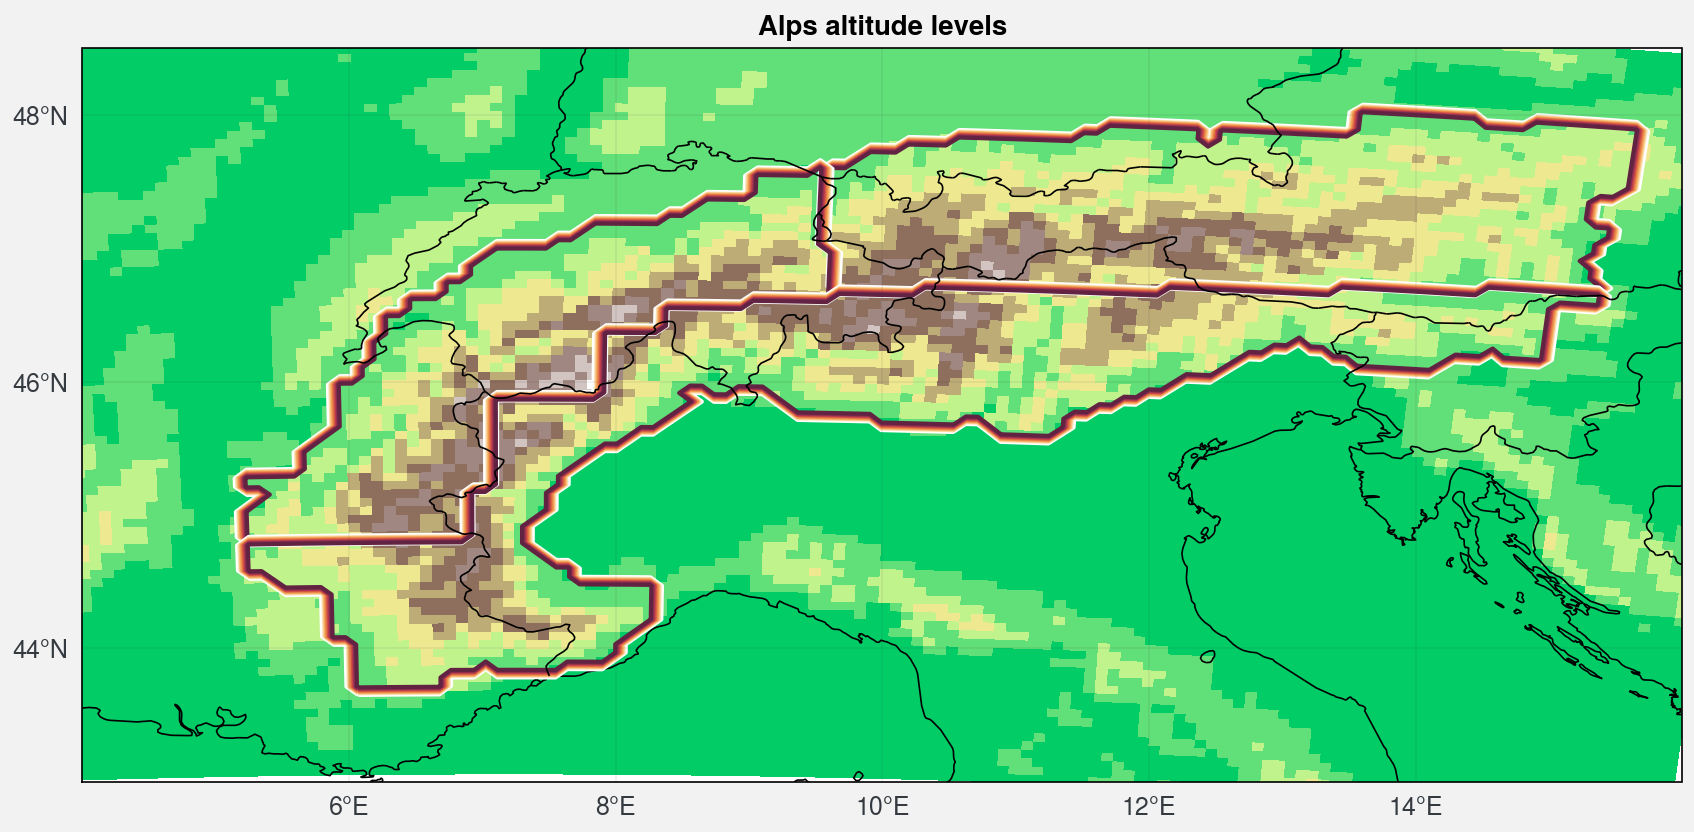

In [33]:
f, ax = pplt.subplots(proj='cyl', axwidth=8)

#H_east_alps = np.ma.masked_array(H, mask=np.invert(east_alps))

ax.pcolormesh(lon, lat,H,edgecolors='none',cmap=colors_land)
ax.contour(lon, lat,ne_alps)
ax.contour(lon, lat,nw_alps)
ax.contour(lon, lat,s_alps)
ax.format(**normal_format,suptitle='Alps altitude levels')

#### 2nd option

In [34]:
ne_alps = np.copy(alps) # ne : north-east
ne_alps[lat<46.7] = False

In [35]:
nw_alps2 = np.copy(alps) # nw : north-west
nw_alps2[lon>7.9] = False
nw_alps2[lat<45.9] = False
nw_alps2[lat>46.7] = False

nw_alps3 = np.copy(alps) # nw : north-west
nw_alps3[lon>6.9] = False
nw_alps3[lat<44.8] = False
nw_alps3[lat>46.7] = False

nw_alps4 = np.copy(alps) # nw : north-west
nw_alps4[lon>8.3] = False
nw_alps4[lat<46.4] = False
nw_alps4[lat>46.7] = False

nw_alps5 = np.copy(alps) # nw : north-west
nw_alps5[lon>7.1] = False
nw_alps5[lat<45.2] = False
nw_alps5[lat>46.7] = False

nw_alps = np.logical_or(np.logical_or(np.logical_or(nw_alps2,nw_alps3),nw_alps4),nw_alps5)

In [36]:
s_alps = np.logical_and(alps,np.invert(np.logical_or(nw_alps,ne_alps)))

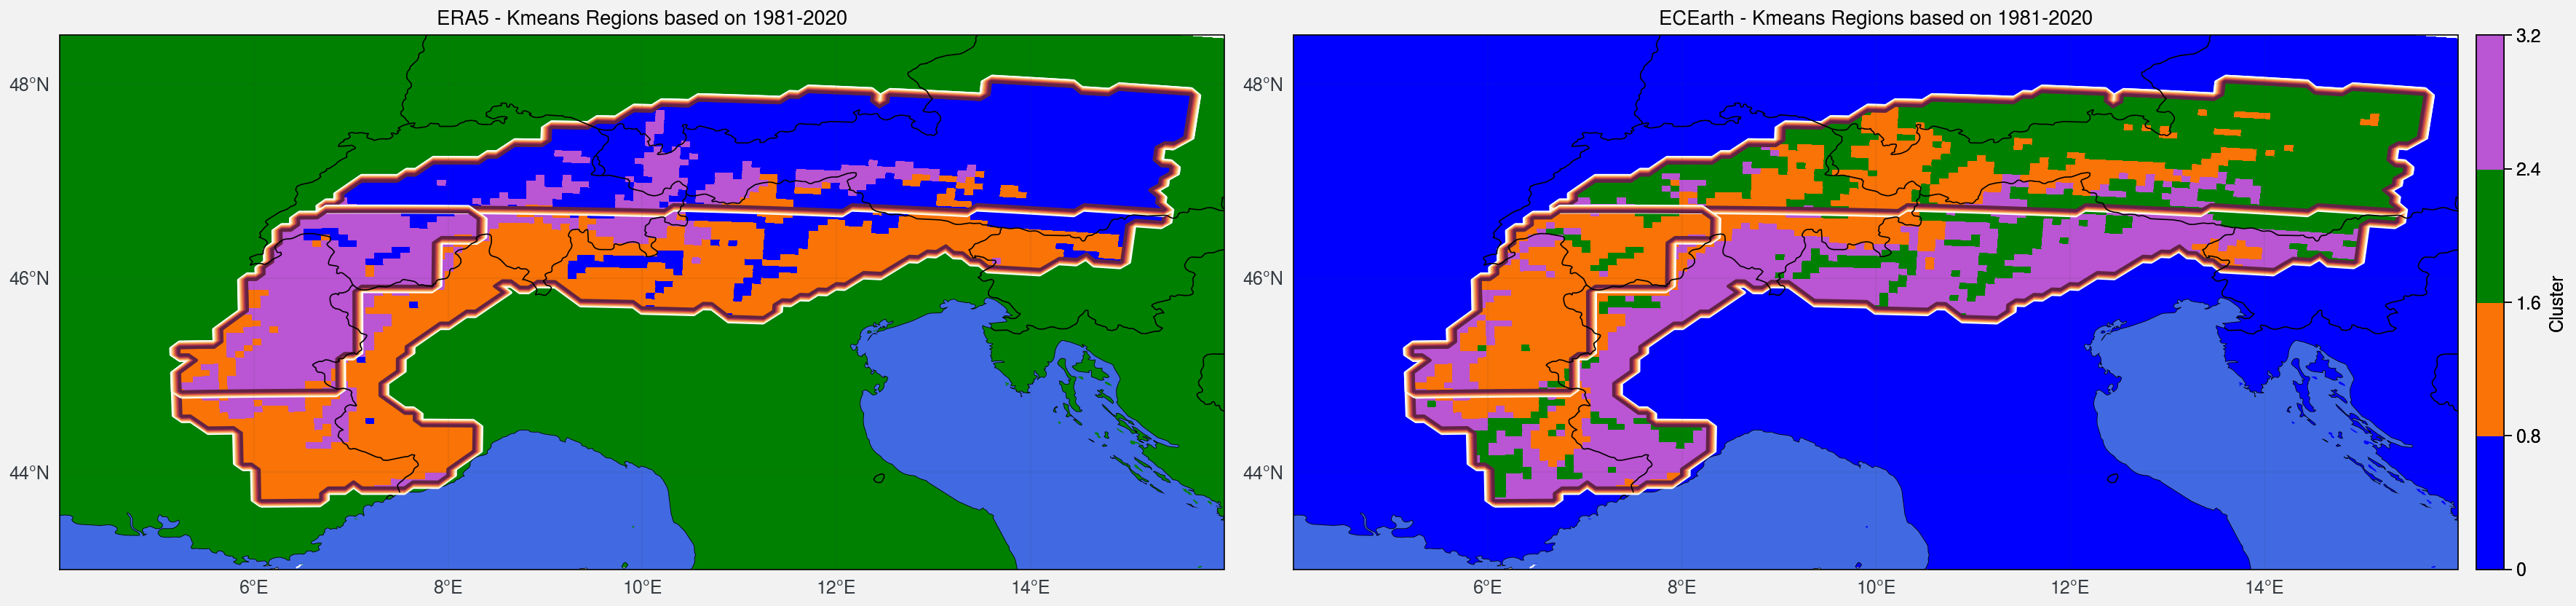

In [37]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)

custom_cmap = ["b","orange","g","mediumorchid"]

# Whole period
m=axs[0].pcolormesh(lon, lat, labels_ERA5+0.1, levels=4,cmap=custom_cmap)
f.colorbar(m,label= 'Cluster')
axs[0].contour(lon, lat,alps)
axs[0].contour(lon, lat,ne_alps)
axs[0].contour(lon, lat,nw_alps)
#axs[0].contour(lon, lat,nw_alps1)
#axs[0].contour(lon, lat,nw_alps2)
#axs[0].contour(lon, lat,nw_alps3)
#axs[0].contour(lon, lat,nw_alps4)
#axs[0].contour(lon, lat,nw_alps5)
axs[0].format(**normal_format,title='ERA5 - Kmeans Regions based on 1981-2020')
axs[0].format(ocean=True,oceancolor='royalblue',reso='hi')

m=axs[1].pcolormesh(lon, lat, labels_ECEarth+0.1, levels=4,cmap=custom_cmap)

axs[1].contour(lon, lat,alps)
axs[1].contour(lon, lat,ne_alps)
axs[1].contour(lon, lat,nw_alps)
#axs[1].contour(lon, lat,nw_alps1)
#axs[1].contour(lon, lat,nw_alps2)
#axs[1].contour(lon, lat,nw_alps3)
#axs[1].contour(lon, lat,nw_alps4)
#axs[1].contour(lon, lat,nw_alps5)
axs[1].format(**normal_format,title='ECEarth - Kmeans Regions based on 1981-2020')
axs[1].format(ocean=True,oceancolor='royalblue',reso='hi')

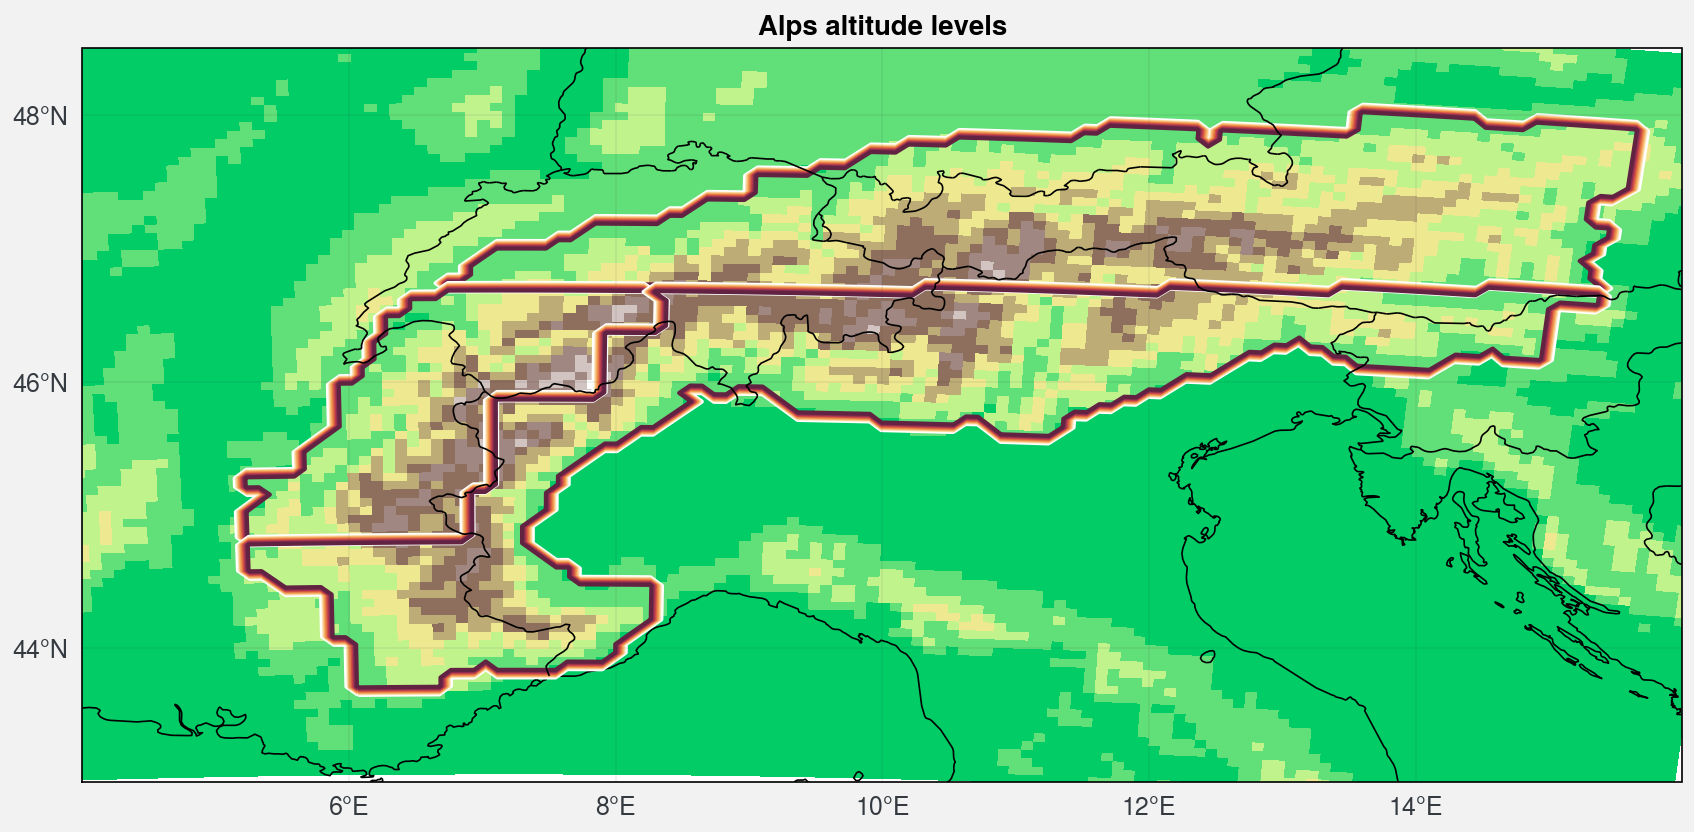

In [38]:
f, ax = pplt.subplots(proj='cyl', axwidth=8)

#H_east_alps = np.ma.masked_array(H, mask=np.invert(east_alps))

ax.pcolormesh(lon, lat,H,edgecolors='none',cmap=colors_land)
ax.contour(lon, lat,ne_alps)
ax.contour(lon, lat,nw_alps)
ax.contour(lon, lat,s_alps)
ax.format(**normal_format,suptitle='Alps altitude levels')